In [4]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
import sys

In [5]:
from pybaseball import statcast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pybaseball import batting_stats
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

Find the important features in predicting MVP. Using data from MLB since 2012. 
I used players with a WAR above 6 and more than 300PA
WRc+ or adjusted OBP is the best predictor for MVP

In [18]:
df = batting_stats(2012, 2020, league='all')
df.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
4,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,0.131,110.6,217,0.5,434,0.220,0.270,NaN,NaN,NaN
15,10155,2013,Mike Trout,LAA,21,157,589,716,190,115,...,NaN,NaN,0,NaN,0,0.200,0.266,NaN,NaN,NaN
41,10155,2012,Mike Trout,LAA,20,139,559,639,182,117,...,NaN,NaN,0,NaN,0,0.221,0.293,NaN,NaN,NaN
46,9166,2012,Buster Posey,SFG,25,148,530,610,178,114,...,NaN,NaN,0,NaN,0,0.190,0.251,NaN,NaN,NaN
20,10155,2016,Mike Trout,LAA,24,159,549,681,173,107,...,0.134,117.1,167,0.4,417,0.188,0.259,NaN,NaN,NaN


In [19]:
df.shape

(1277, 319)

In [20]:
df = df[df['PA'] >= 300]
df.shape

#players over 300 PA

(1135, 319)

In [21]:
WAR_info = df.loc[df['WAR'] >= 6.0]
WAR_info

#players with a WAR above 6

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
4,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,0.131,110.6,217,0.500,434,0.220,0.270,NaN,NaN,NaN
15,10155,2013,Mike Trout,LAA,21,157,589,716,190,115,...,NaN,NaN,0,NaN,0,0.200,0.266,NaN,NaN,NaN
41,10155,2012,Mike Trout,LAA,20,139,559,639,182,117,...,NaN,NaN,0,NaN,0,0.221,0.293,NaN,NaN,NaN
46,9166,2012,Buster Posey,SFG,25,148,530,610,178,114,...,NaN,NaN,0,NaN,0,0.190,0.251,NaN,NaN,NaN
20,10155,2016,Mike Trout,LAA,24,159,549,681,173,107,...,0.134,117.1,167,0.400,417,0.188,0.259,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,9077,2015,Lorenzo Cain,KCR,29,140,551,604,169,113,...,0.046,111.0,174,0.381,457,0.147,0.231,NaN,NaN,NaN
49,9218,2013,Paul Goldschmidt,ARI,25,160,602,710,182,107,...,NaN,NaN,0,NaN,0,0.186,0.270,NaN,NaN,NaN
142,12564,2019,Trevor Story,COL,26,145,588,656,173,95,...,0.077,111.8,192,0.460,417,0.141,0.260,NaN,NaN,NaN
141,9847,2015,Andrew McCutchen,PIT,28,157,566,685,165,103,...,0.086,111.4,195,0.441,442,0.142,0.246,NaN,NaN,NaN


In [22]:
df['MVP'] = df['WAR'] >= 6.0
df['MVP']

#MVP column- True/False if the player won MVP

4        True
15       True
41       True
46       True
20       True
        ...  
1262    False
1256    False
1223    False
1210    False
1276    False
Name: MVP, Length: 1135, dtype: bool

In [24]:
df['MVP'] = df['MVP'].replace('True', 1)
df['MVP'] = df['MVP'].replace('False', 0)

In [25]:
# Train/Test/Val split

train = df[df['Season'] <= 2015.0]
val = df[df['Season'] == 2016.0]
test = df[df['Season'] >= 2017.0]

In [26]:
train.shape, val.shape, test.shape

((570, 320), (146, 320), (419, 320))

In [27]:
features = ['LD%', 'wRC+', 'OPS', 'wOBA', 'ISO', 'H', 'HR', 'RBI', 'BABIP', 'BB']
target = 'WAR'

In [28]:
train[target].value_counts(normalize=True)

 3.4    0.031579
 2.5    0.028070
 1.8    0.028070
 2.4    0.026316
 3.2    0.026316
          ...   
 6.3    0.001754
-1.6    0.001754
 7.8    0.001754
 8.6    0.001754
 6.7    0.001754
Name: WAR, Length: 101, dtype: float64

In [29]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val = val[features]
y_val = val[target]

In [30]:
# Fit Linear Regression Model
# Baseline
lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(),
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.6421752345780098


In [31]:
from sklearn.linear_model import LinearRegression
# Instantiate model class
model = LinearRegression()

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Random Forest Regression Model
# Baseline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5955626812563365


In [34]:
# Instantiate one-hot encoder
encoder = ce.OneHotEncoder()

# Fit and transform on train/test sets
X_train1 = encoder.fit_transform(X_train)
X_test1 = encoder.transform(X_test)

X_train1

,LD%,wRC+,OPS,wOBA,ISO,H,HR,RBI,BABIP,BB
15,0.230,176,0.988,0.423,0.234,190,27,97,0.376,110
41,0.226,167,0.963,0.409,0.238,182,30,83,0.383,67
46,0.246,164,0.957,0.406,0.213,178,24,103,0.368,69
1,0.222,197,1.109,0.461,0.319,172,42,99,0.369,124
25,0.244,171,0.991,0.415,0.290,172,41,90,0.344,92
...,...,...,...,...,...,...,...,...,...,...
993,0.195,94,0.710,0.311,0.148,120,14,55,0.282,48
1160,0.246,90,0.685,0.295,0.126,134,15,62,0.292,29
1151,0.229,79,0.682,0.297,0.093,169,8,67,0.299,33
1140,0.244,84,0.669,0.298,0.111,114,12,54,0.265,45


In [35]:

# Instantiate model class
model = LinearRegression()
# Fit the model
model.fit(X_train1, y_train)
# Apply the model to new data
y_pred1 = model.predict(X_train1)
y_pred2 = model.predict(X_test1)

In [36]:
# xgboost

from xgboost import XGBRegressor

# Instantiate and fit one-hot encoder
encoder = ce.OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.fit_transform(X_test)

# Instantiate XGBRegressor and parameter tuning
model = XGBRegressor(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)
# Instantiate eval_set
eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

# Fit model to the eval_set
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='mae', 
          early_stopping_rounds=50)

[0]	validation_0-mae:1.44003	validation_1-mae:1.63235
[1]	validation_0-mae:0.91136	validation_1-mae:1.23906
[2]	validation_0-mae:0.63415	validation_1-mae:1.10988
[3]	validation_0-mae:0.49977	validation_1-mae:1.08491
[4]	validation_0-mae:0.43481	validation_1-mae:1.06516
[5]	validation_0-mae:0.36997	validation_1-mae:1.08197
[6]	validation_0-mae:0.31778	validation_1-mae:1.08003
[7]	validation_0-mae:0.27626	validation_1-mae:1.08261
[8]	validation_0-mae:0.24191	validation_1-mae:1.08619
[9]	validation_0-mae:0.23368	validation_1-mae:1.08613
[10]	validation_0-mae:0.21005	validation_1-mae:1.08595
[11]	validation_0-mae:0.18989	validation_1-mae:1.08733
[12]	validation_0-mae:0.17610	validation_1-mae:1.08605
[13]	validation_0-mae:0.16177	validation_1-mae:1.08430
[14]	validation_0-mae:0.14783	validation_1-mae:1.08416
[15]	validation_0-mae:0.12423	validation_1-mae:1.08366
[16]	validation_0-mae:0.10707	validation_1-mae:1.08377
[17]	validation_0-mae:0.09623	validation_1-mae:1.08448
[18]	validation_0-ma

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [37]:
# Calculate r2 for the train and test data
y_pred1 = model.predict(X_train_encoded)
y_pred2 = model.predict(X_test_encoded)
r2 = r2_score(train[target], y_pred1)
print(f'The R2 of the training data is {r2}')
r2 = r2_score(test[target], y_pred2)
print(f'The R2 of the test data is {r2}')

The R2 of the training data is 0.9168575182620756
The R2 of the test data is 0.5666447405585279


In [41]:
import eli5
from eli5.sklearn import PermutationImportance
# Instantiate permuter for XGBRegressor
permuter = PermutationImportance(
    model,
    scoring='r2',
    n_iter=5,
    random_state=42
)
# Fit permuter to data from our model
permuter.fit(X_train_encoded, y_train)

PermutationImportance(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1,
                                             enable_categorical=False, gamma=0,
                                             gpu_id=-1, importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.5,
                                             max_delta_step=0, max_depth=7,
                                             min_child_weight=1, missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=1000, n_jobs=-1,
                                             num_parallel_tree=1,
                                             predictor='auto', 

In [42]:
# Pull out top features and their importance

feature_names = X_train_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

HR       0.054924
LD%      0.066559
ISO      0.074352
BABIP    0.082446
RBI      0.088452
OPS      0.089354
BB       0.108486
wOBA     0.124815
H        0.319999
wRC+     0.982340
dtype: float64

In [43]:

# Visualize feature importances 
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.9823 ± 0.0946,wRC+
0.3200 ± 0.0374,H
0.1248 ± 0.0204,wOBA
0.1085 ± 0.0349,BB
0.0894 ± 0.0154,OPS
0.0885 ± 0.0129,RBI
0.0824 ± 0.0098,BABIP
0.0744 ± 0.0123,ISO
0.0666 ± 0.0110,LD%
0.0549 ± 0.0067,HR


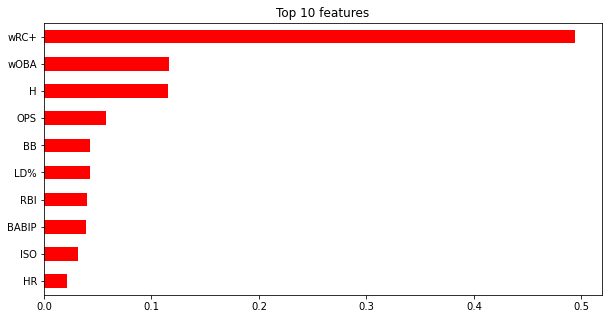

In [44]:

# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='red');